In [1]:
%matplotlib inline
import os
import numpy as np
import esmlab

import ncar_jobqueue
from dask.distributed import Client

import utils
import climo_utils as cu
import ann_avg_utils as aau
units, _ = aau.get_pint_units()

import xpersist as xp
# Set up xperist cache
cache_dir = os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects', 'cesm2-marbl', 'xpersist_cache', '3d_fields')
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

numpy         1.17.3
esmlab        2019.4.27
xpersist      0.0.post25
ncar_jobqueue 2019.10.16.1
Mike Levy 2020-02-20 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper20
Git hash   : 6158bcf88274da32ccd24c8af2aff716eb67b7cd


In [2]:
cluster = ncar_jobqueue.NCARCluster(project='P93300606')
cluster.adapt(minimum_jobs=0, maximum_jobs=24)
client = Client(cluster)
client

Client Scheduler: tcp://128.117.181.226:35680 Dashboard: https://jupyterhub.ucar.edu/dav/user/mlevy/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
%%time

def _compute_ds_surf():
    PFTs = ['sp', 'diat', 'diaz']
    for n, PFT in enumerate(PFTs):
        # Read CESM and WOA data
        variable = f'{PFT}Chl'
        ds_tmp = cu.read_CESM_var(slice("1990-01-15", "2015-01-15"), variable, mean_dims='member_id').isel(z_t_150m=0) # 1990 - 2014, inclusive
        if n == 0:
            ds_surf = ds_tmp.rename({variable : 'totChl'})
        else:
            ds_surf['totChl'] = ds_surf['totChl'] + ds_tmp.rename({variable : 'totChl'})['totChl']
        del(ds_tmp)
    return ds_surf

xp_func = xp.persist_ds(_compute_ds_surf, name=f'totChl', trust_cache=True)
ds_surf = xp_func()

ds_surf_avg = ds_surf.mean(dim='time')
da_surf_avg = ds_surf_avg['totChl']

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/totChl.nc
CPU times: user 598 ms, sys: 1.05 s, total: 1.65 s
Wall time: 3.79 s


/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [4]:
ds_surf_obs = cu.read_obs(src='SeaWiFS', freq='ann')['chl_gsm'].to_dataset(name='totChl')

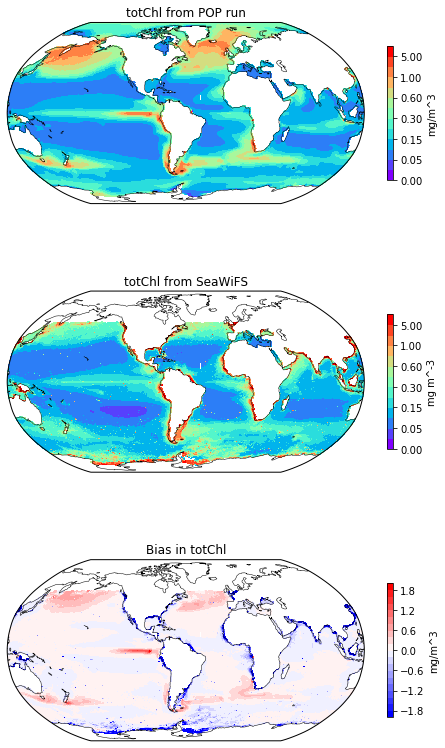

In [5]:
cu.plot_surface_vals('totChl', ds_surf_avg, da_surf_avg, ds_surf_obs['totChl'], obs_src='SeaWiFS',
                     levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20],
                     bias_levels=np.linspace(-2, 2, 21))

## Hovmöller plots for zonal means in Atlantic and Pacific

x-axis should be latitude, y axis should be time (`month`?)

In [6]:
ds_ann = ds_surf.drop(['dz', 'z_t']).groupby('time.month').mean()
ds_ann['month'].data = np.arange(12, dtype=np.int32)
ds_ann['month'].encoding['dtype'] = np.int32
ds_ann['month'].attrs['_FillValue'] = np.int32(-100)

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
ds_obs_ann = cu.read_obs(src='SeaWiFS', freq='monthly')['chl_gsm'].to_dataset(name='totChl')

# recast 'month' as integers to allow introduction of _FillValue
# (kludge for the zonal mean executable)
ds_obs_ann['month'].data = np.arange(12, dtype=np.int32)
ds_obs_ann['month'].encoding['dtype'] = np.int32
ds_obs_ann['month'].attrs['_FillValue'] = np.int32(-100)

In [8]:
kwargs = {'grid' : 'gx1v7'}
kwargs['rmask_file'] = os.path.join(os.path.sep,
                                    'glade',
                                    'p',
                                    'cgd',
                                    'oce',
                                    'people',
                                    'klindsay',
                                    'oldcgdoce',
                                    'REGION_MASK',
                                    'new_REGION_MASK_gx1v6.nc')
regions = dict()
regions['Pacific Ocean'] = 1
regions['Atlantic Ocean'] = 3

da_zonal_mean = utils.zonal_mean_via_fortran(ds_ann, 'totChl', **kwargs)
da_zonal_mean_obs = utils.zonal_mean_via_fortran(ds_obs_ann, 'totChl', **kwargs)

za ran successfully, writing netcdf output
za ran successfully, writing netcdf output


In [9]:
def hovmoller_plots(da_zonal_mean, da_zonal_mean_obs, region):
    import matplotlib.pyplot as plt
#     import cartopy
#     import cartopy.crs as ccrs

    levels=[0, 0.1, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4]
    bias_levels = [-4, -3, -2.5, -2, -1.5, -1, -0.75, -0.5, -0.35, -0.2, -0.1, 0, 0.1, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4]
    fig = plt.figure(figsize=(8, 17))
    ax = plt.subplot(3, 1, 1)
    subfig = da_zonal_mean.isel(basins=regions[region]).totChl.plot(levels=levels, extend='max')
    ax.set_title(f'{region} from POP run')
    ax.set_yticks(np.arange(12))
    ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(np.linspace(-90, 90, 19))
    ax.set_xticklabels('')

    ax = plt.subplot(3, 1, 2)
    da_zonal_mean_obs.isel(basins=regions[region]).totChl.plot(levels=levels, extend='max')
    ax.set_title(f'{region} from SeaWiFS')
    ax.set_yticks(np.arange(12))
    ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(np.linspace(-90, 90, 19))
    ax.set_xticklabels('')

    ax = plt.subplot(3, 1, 3)
    (da_zonal_mean - da_zonal_mean_obs).isel(basins=regions[region]).totChl.plot(levels=bias_levels, extend='neither')
    ax.set_title(f'Bias')
    ax.set_yticks(np.arange(12))
    ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_ylabel('')
    ax.set_xticks(np.linspace(-90, 90, 19))
    # For bottom panel, set up tick labels at -90, -60, -30, 0, 30, 60, and 90
    xticklabels = list(np.linspace(-90, 90, 7, dtype='int'))
    for i in range(18):
        if i%3:
            xticklabels.insert(i, '')

    ax.set_xticklabels(xticklabels)



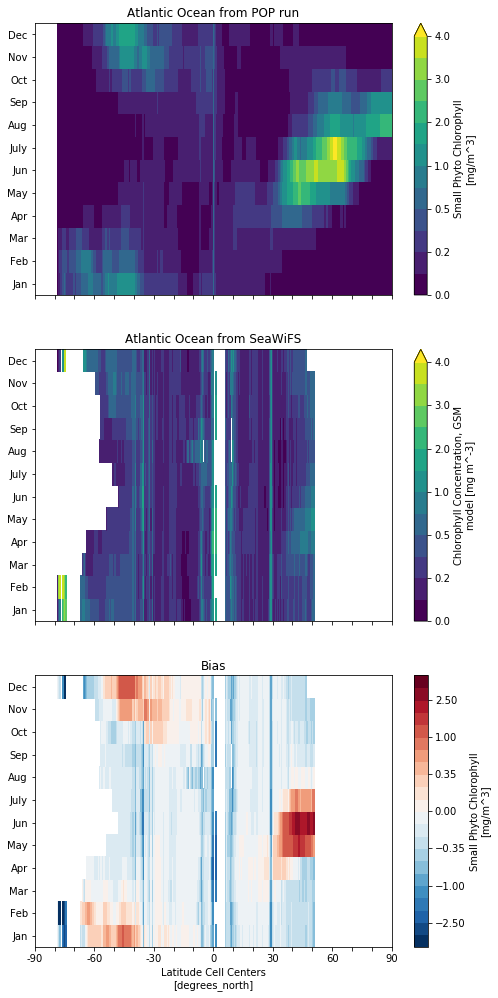

In [10]:
hovmoller_plots(da_zonal_mean, da_zonal_mean_obs, 'Atlantic Ocean')

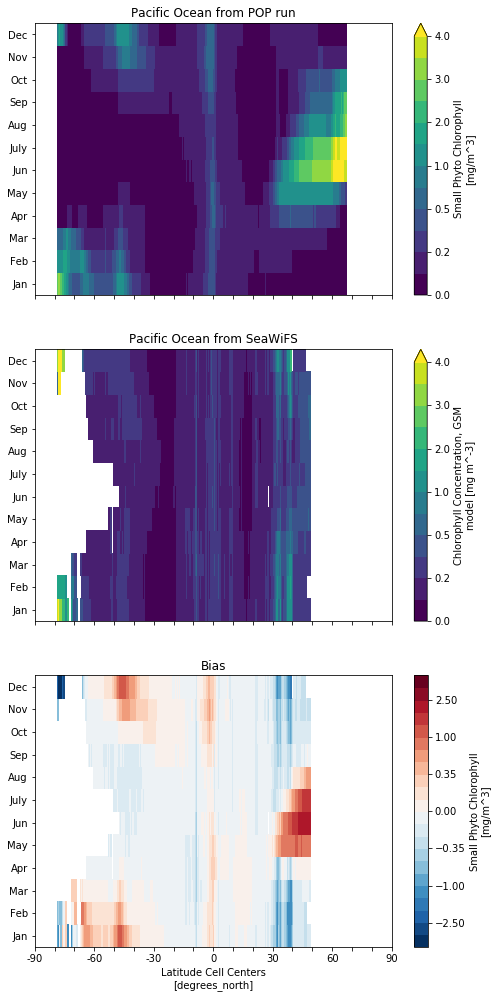

In [11]:
hovmoller_plots(da_zonal_mean, da_zonal_mean_obs, 'Pacific Ocean')